In [19]:
import os.path as op
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gradec.decode import LDADecoder
from gradec.utils import _rm_medial_wall, _decoding_filter
from gradec.plot import plot_surf_maps, plot_radar, plot_cloud
from gradec.fetcher import _fetch_features, _fetch_frequencies, _fetch_classification
import nibabel as nib

### Determine tract names given a data folder with white matter probability atlas

In [25]:
# Path to white matter probability atlas
data_dir = op.join(".", "data")
endpt_dir = op.join(
    data_dir, 
    "white-matter-atlas_thresholds", 
    f"cortexmap_binarize_smooth-surf-1_threshold-0_dilate-0", # MAY NEED TO MODIFY FILE PATH
    "cortexmap", 
    "func",
)

# extract all .gii file names
file_names = []
for f in os.listdir(endpt_dir):
    if f.endswith(".gii"):
        file_names.append(f)

tracts_names = [] # all tract names differeniating between left and right tract (ex. left CST and right CST treated as 2 tracts)

# extract tract name from file name
for i in file_names:
    if ("rh.left" in i) or ("lh.right" in i) or ('spino' in i) or ('Cerebellar' in i):
        continue # exclude if file name "rh.left..." or "lh.right..." or spinal/cerebellar tracts
    else:
        tracts_names.append(i.split("_")[0][len('rh.'):])

ALL_TRACT_NAMES = sorted(list(set(tracts_names)))
print("# of tracts: ", len(ALL_TRACT_NAMES)) # check that there are 45 tracts

# of tracts:  45


### Define space, density and paths to data

In [4]:
SPACE, DENSITY = "fsaverage", "164k"
DSET, MODEL = "neuroquery", "lda"

neuromaps_dir = op.join(data_dir, "neuromaps")
figures_dir = op.join(data_dir, "figures")

# List of posssible combinations of tracts, end points and smoothing
tracts = ALL_TRACT_NAMES
endpts = ["RAS", "LPI"]

# Dictionaries for the title of the figures
TRACTS_DICT = dict(zip(ALL_TRACT_NAMES, ALL_TRACT_NAMES))
ENDPOINTS_DICT = { 
    "LPI": "Left-Posterior-Inferior",
    "RAS": "Right-Anterior-Superior",
}

### Train and LDA-based decoder on NeuroQuery detabase

In [5]:
decode = LDADecoder(space=SPACE, density=DENSITY, calc_pvals=False, data_dir=data_dir)
decode.fit(DSET)

# Load features for analysis or visualization
features = _fetch_features(DSET, MODEL, data_dir=data_dir)
frequencies = _fetch_frequencies(DSET, MODEL, data_dir=data_dir)
classification, class_lst = _fetch_classification(DSET, MODEL, data_dir=data_dir)

### Define functions to run decoder

In [6]:
def load_maps_per_tract(endpt_dir, tract):
    """
    This function loads maps when running analysis per tract (ex. leftCST and rightCST = 2 tracts)

    Parameters
    endpt_dir (str): file directory where the white matter end point atlases are stored
    tract (str): full name of tract (ex. can include whether tract is 'left' or 'right' tract)

    Returns
    map_arr_lh (1D array): white matter probability map for left hemisphere
    map_arr_rh (1D array): white matter probability map for right hemisphere
    """
    if 'left' in tract:
        # file names
        map_lpi_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
        map_ras_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
        map_lpi_arr_lh = nib.load(map_lpi_lh).agg_data()
        map_ras_arr_lh = nib.load(map_ras_lh).agg_data()
        map_arr_lh = np.maximum(map_lpi_arr_lh, map_ras_arr_lh) # Take the maximum to address overlap
        map_arr_rh = np.zeros_like(map_arr_lh) # load blank right hemisphere
    elif 'right' in tract:
        map_lpi_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
        map_ras_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
        map_lpi_arr_rh = nib.load(map_lpi_rh).agg_data()
        map_ras_arr_rh = nib.load(map_ras_rh).agg_data()
        map_arr_rh = np.maximum(map_lpi_arr_rh, map_ras_arr_rh) # Take the maximum to address overlap
        map_arr_lh = np.zeros_like(map_arr_rh) # load blank left hemisphere
    else: # if mono tract
        # file names
        map_lpi_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
        map_ras_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
        map_arr_lh = nib.load(map_lpi_lh).agg_data()
        map_arr_rh = nib.load(map_ras_rh).agg_data()
        
    return map_arr_lh, map_arr_rh

### Analysis: Run decoder for each tract

In [18]:
tracts_to_analyze = ALL_TRACT_NAMES # modify to just run a few tracts
map_corr_df = pd.DataFrame(columns=['ROI', 'topic', 'r']) # 104 topics*33 ROIs data table in long form

for tract in tracts_to_analyze:
    # Read map
    map_arr_lh, map_arr_rh = load_maps_per_tract(endpt_dir, tract)

    # Remove medial wall
    map_arr = _rm_medial_wall(
        map_arr_lh,
        map_arr_rh,
        space=SPACE,
        density=DENSITY,
        neuromaps_dir=neuromaps_dir,
    )

    ''' UNCOMMENT THIS SECTION IF YOU WANT TO GENERATE SURFACE PLOTS - THIS WILL RESULT IN LONGER RUNTIME
    # Visualize maps to decode
    surf_fig = plot_surf_maps(
        map_arr_lh, 
        map_arr_rh, 
        space=SPACE, 
        density=DENSITY, 
        cmap="YlOrRd",
        color_range=(0, 1),
        data_dir=data_dir,
        out_fig=op.join(figures_dir, f"{tract}_LPI+RAS_thr-0_surf.png"),
    ) 
    '''

    # Decode map and calculate correlation of activation map and white matter termination map
    temp_corrs_df = decode.transform([map_arr], method="correlation") # vertex-wise Pearson's r

    # filter to keep only the function-related topics
    filtered_df, filtered_features, filtered_frequencies = _decoding_filter(
        temp_corrs_df,
        features,
        classification,
        pos_corr = False,
        freq_by_topic=frequencies,
        class_by_topic=class_lst,
    )

    # transform and concat into single df for clustering
    filtered_df = filtered_df.rename(columns={0: 'r'})
    sorted_df = filtered_df.sort_values(by="r", ascending=False)
    map_corr_df = pd.concat([map_corr_df, 
                             pd.DataFrame({'ROI': f"{tract}", # this is a tract (2 ROIs combined LPI+RAS)
                                           'topic': sorted_df.index, 
                                           'r': sorted_df['r']})], 
                                           ignore_index=True)

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_130825/3720763054.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  map_corr_df = pd.concat([map_corr_df,


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

### Analysis: Hierarchical cluster analysis
The below section consists of 
1. computing the correlation matrix
2. checking conditions
3. computing HCA and plotting dendrogram
4. computing the cophenetic correlation coeff

In [8]:
# constant to choose whether to cluster by topic or endpoint ROI
TOPIC = 't'
ROI = 'r'

clusterby = ROI # MAY NEED TO CHANGE THIS

# transform and clean df
if clusterby == ROI:
    pivot_df = map_corr_df.pivot(index = 'topic', columns='ROI', values='r') # pivot from long to wide
elif clusterby == TOPIC:
    pivot_df = map_corr_df.pivot(index = 'ROI', columns='topic', values='r') # pivot from long to wide
else:
    print("Error: Incorrect clustering method provided")
pivot_df_cleaned = pivot_df.dropna(axis=1) # drop cols with NA values

# compute correlation matrix
corr_mtrix = pivot_df_cleaned.corr(method='pearson') 

#### Check conditions
For example, see if the histogram of r is normally distributed and the heatmap of the correlation coefficient doesn't look too weird

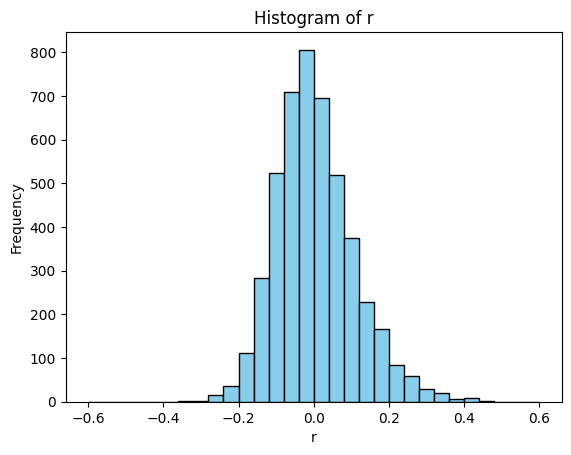

In [9]:
# Create a histogram
plt.hist(map_corr_df['r'], bins=30, range=(-0.6, 0.6),
         color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('r')
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format('r'))

# Show plot
plt.show()

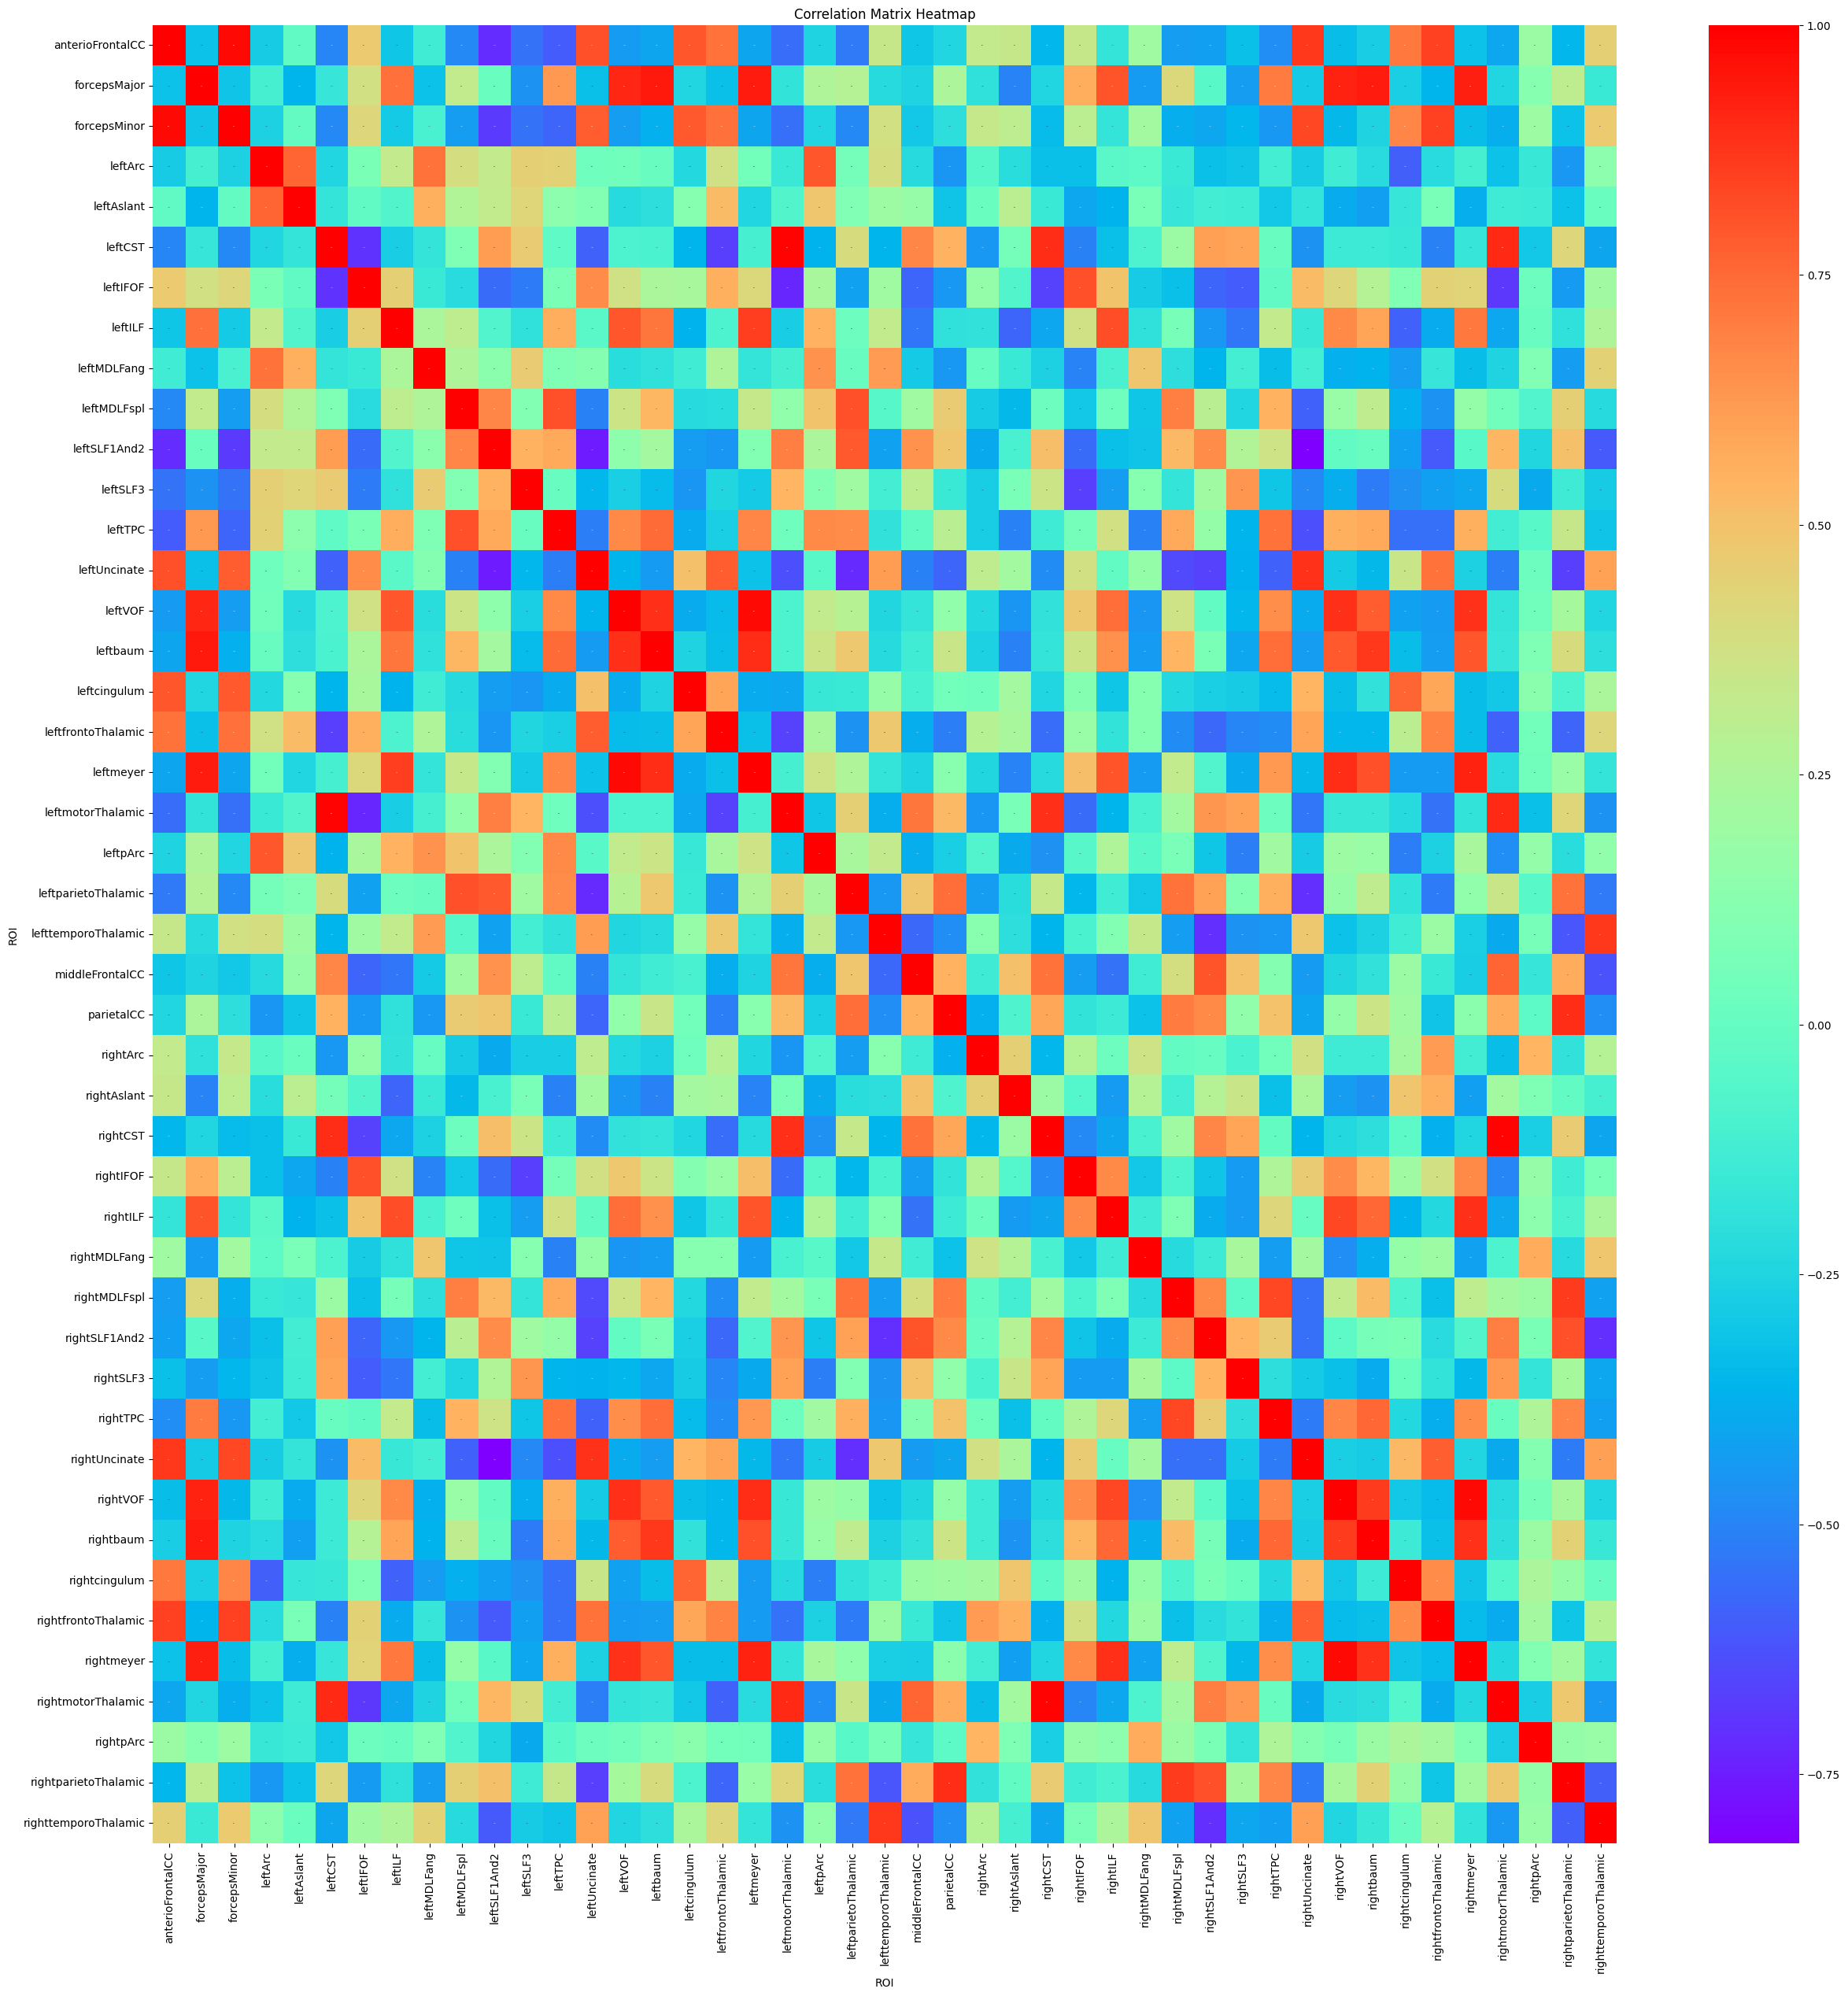

In [10]:
# Intermediate step: plot heatmap of the correlation matrix
plt.figure(figsize=(30, 30))
sns.heatmap(corr_mtrix, annot=True, cmap='rainbow', fmt=".2f", annot_kws={"fontsize": 1})
plt.title('Correlation Matrix Heatmap')
plt.show()

#### Compute HCA and plot dendrogram

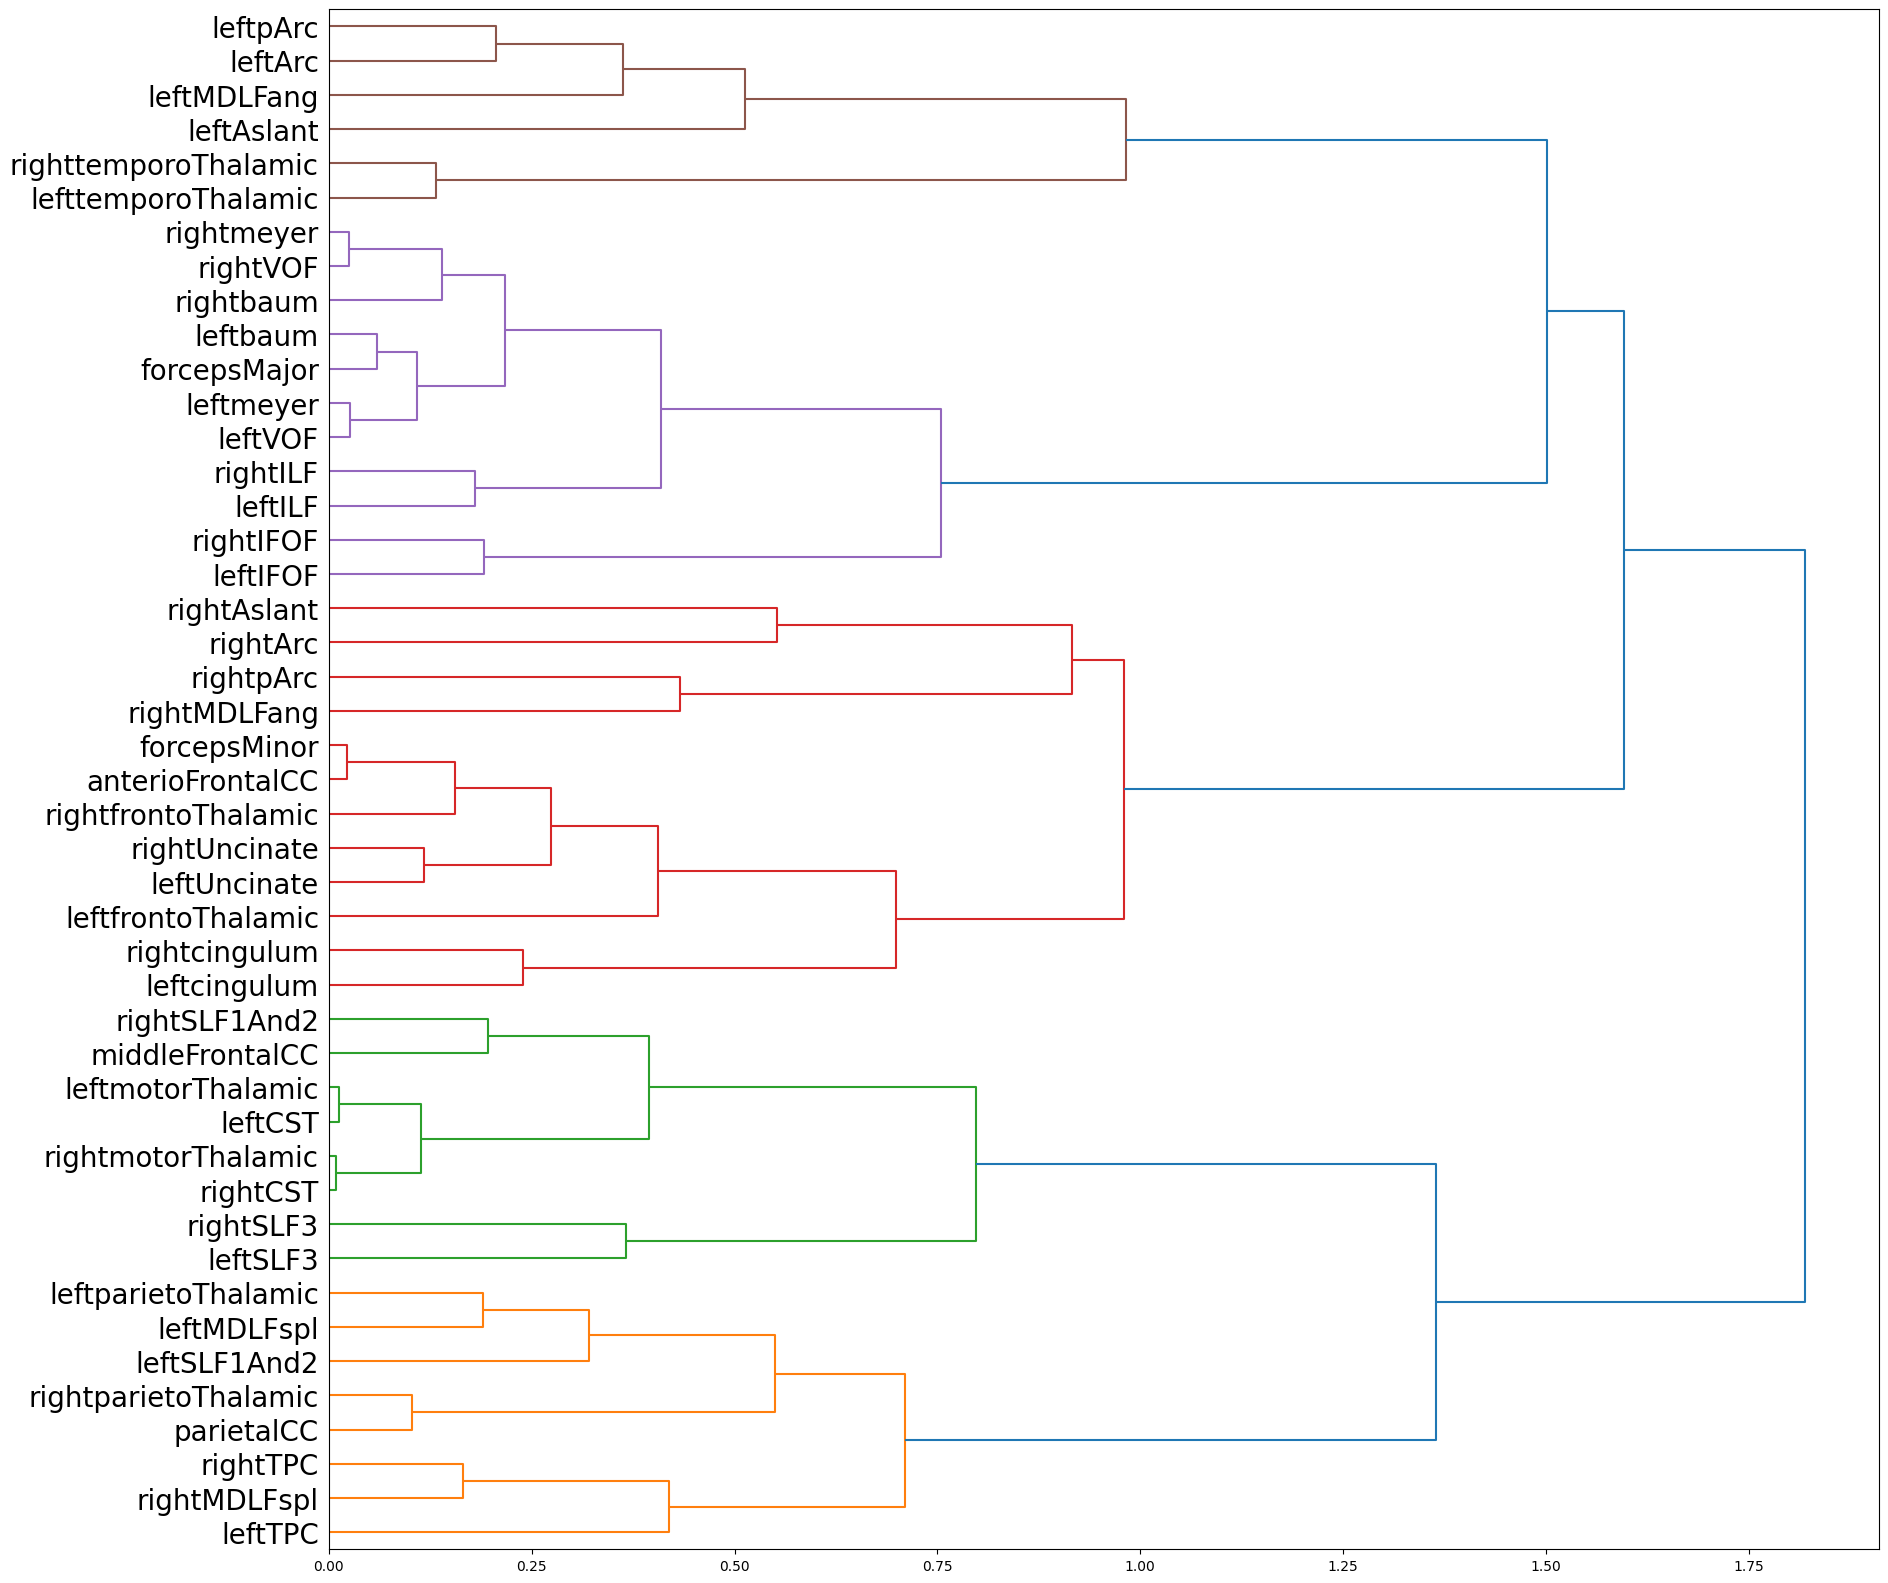

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree, inconsistent, fcluster, cophenet
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

# HCA
link_method = 'complete'
dissimilarity = 1 - corr_mtrix # distance matrix
hca = linkage(squareform(dissimilarity), link_method)

# plot dendrogram
plt.figure(figsize=(20,20))
dendrogram(hca, labels=corr_mtrix.columns, 
           orientation='right',
           leaf_font_size=20)
plt.savefig('./dendro_' + link_method + '.png', 
            bbox_inches = 'tight')

<Figure size 800x600 with 0 Axes>

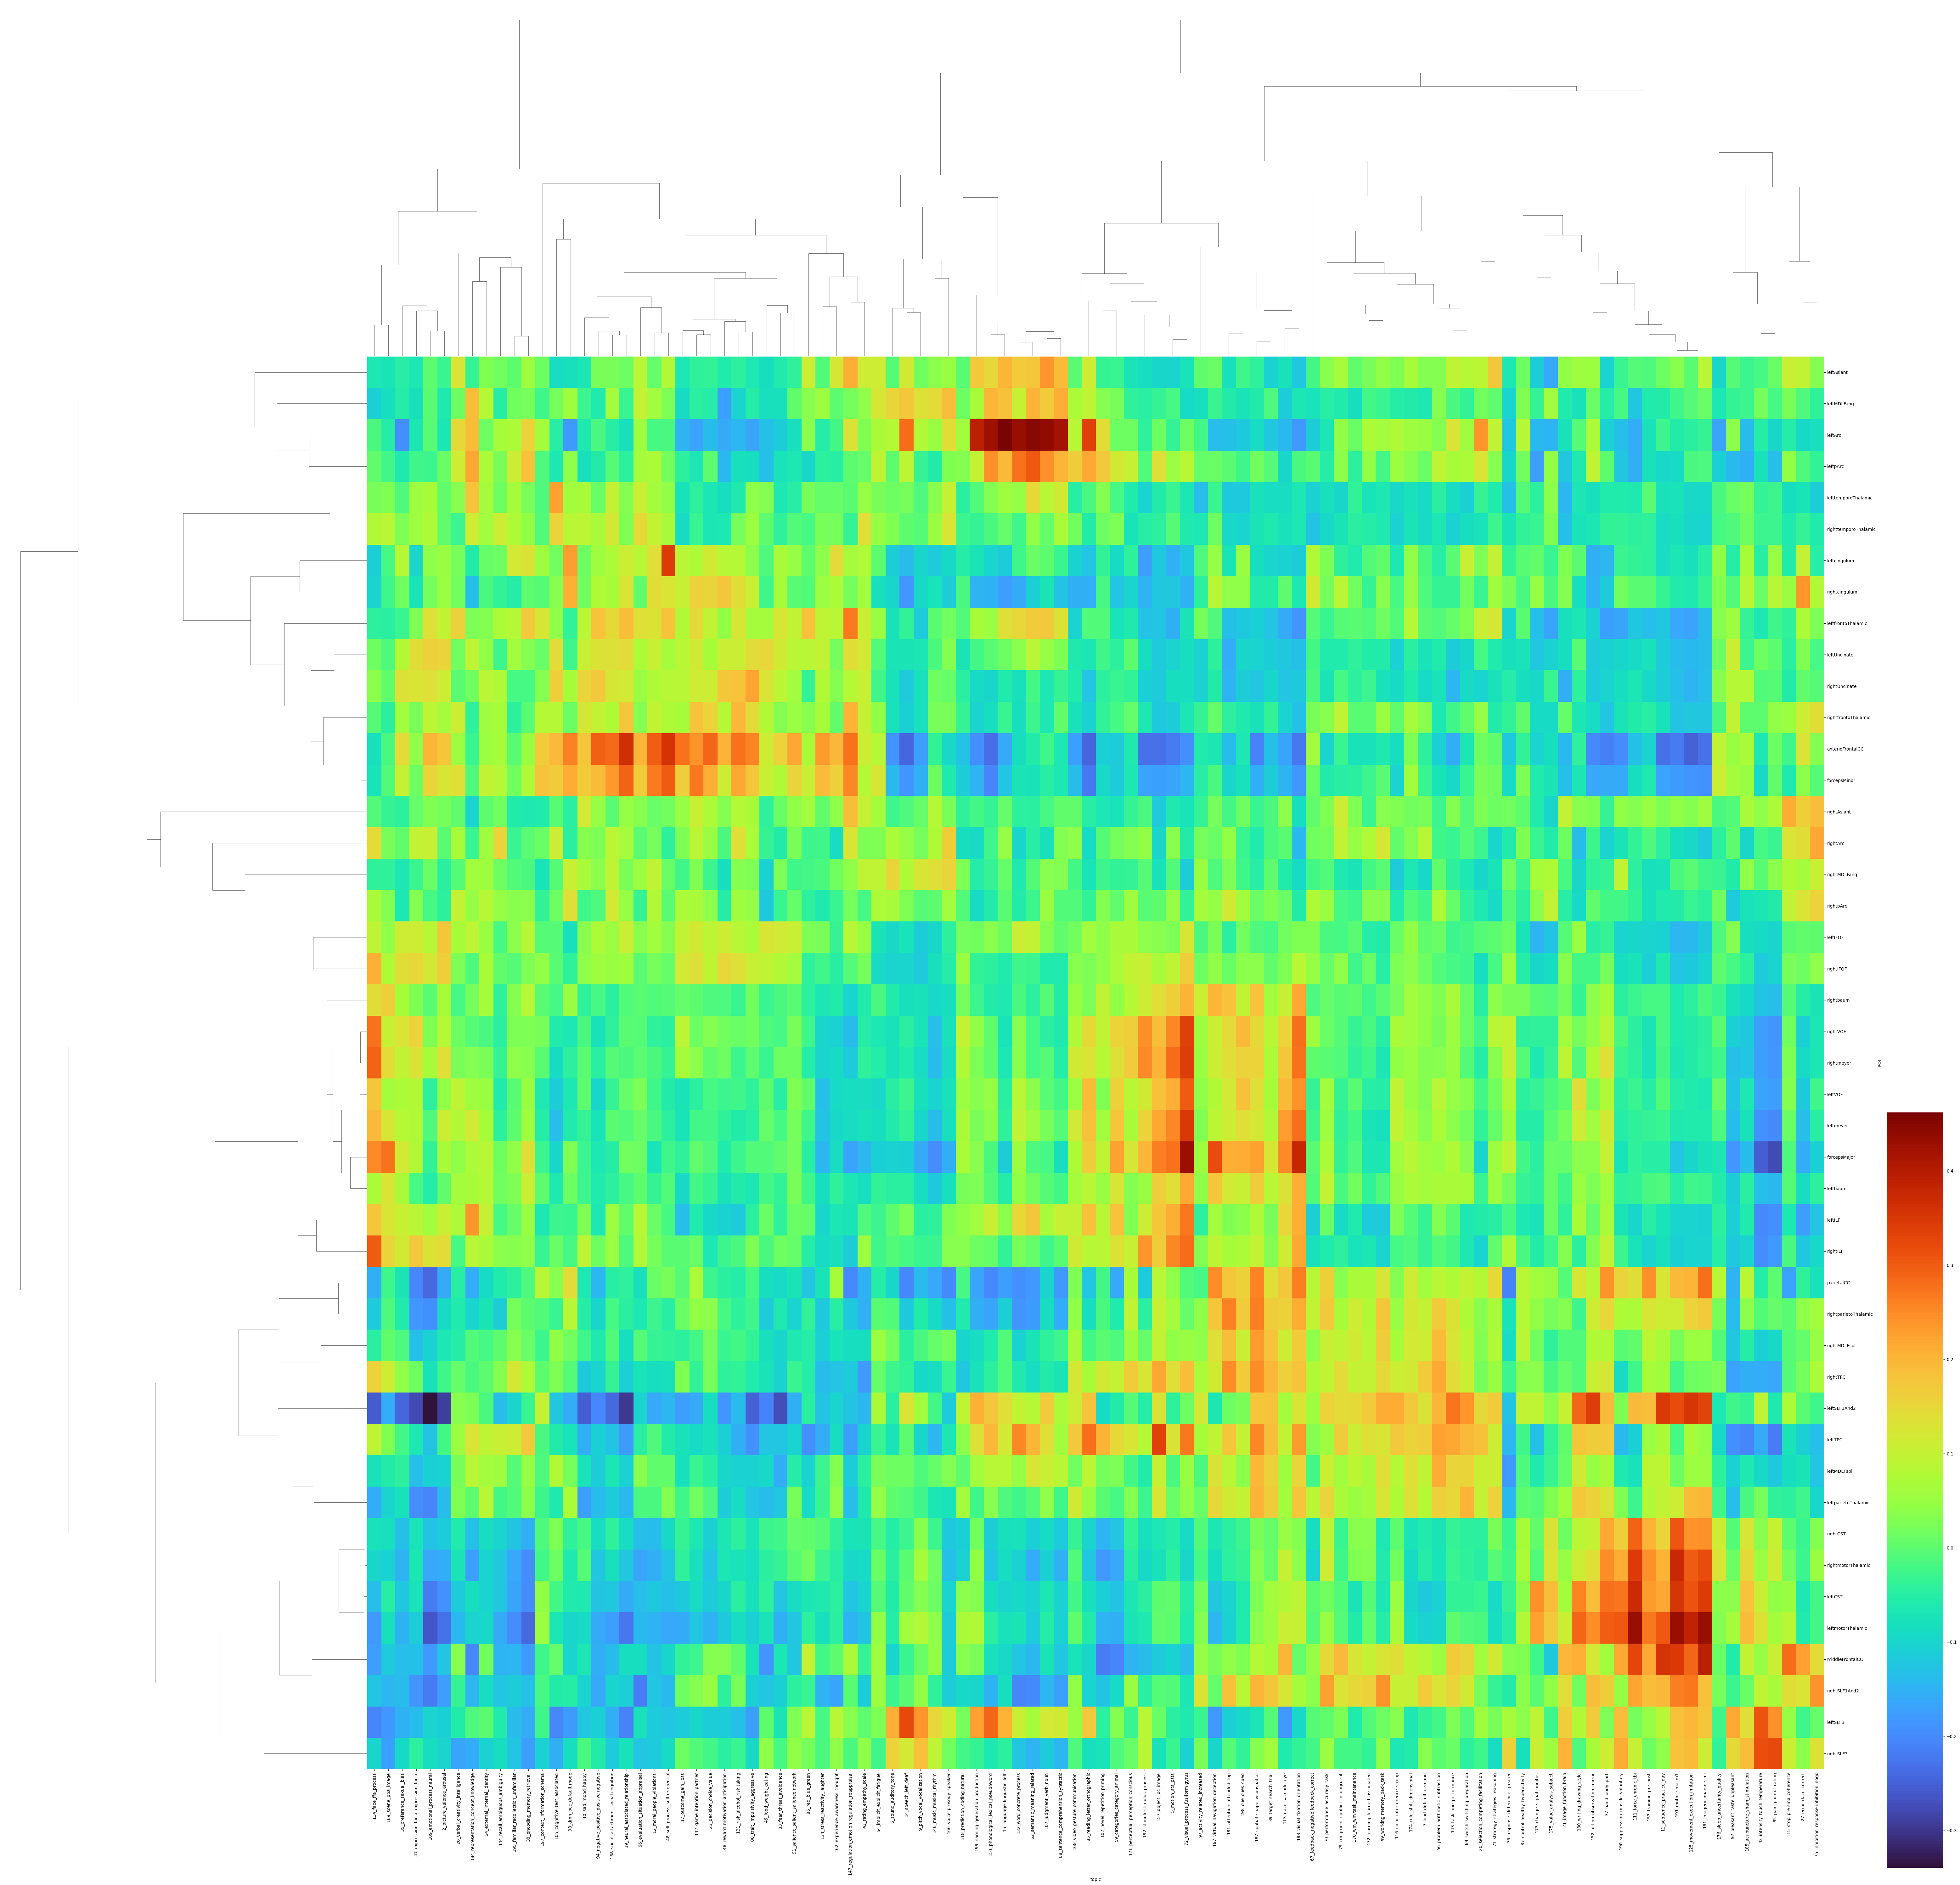

In [16]:
# Plot heatmap of the ordered matric
plt.figure(figsize=(8, 6))
sns.clustermap(pivot_df_cleaned.transpose(), #pivot_df_cleaned.drop(columns=col)
                metric="correlation",
                cmap='turbo', # turbo, terrain, gist_stern, gnuplot2, vlag
                cbar_pos=(1, .01, .03, .4),
                square=False,
                figsize=(60,60)) #50, 50 
plt.savefig("heatmap.png")
plt.show()

#### Compute cophenetic correlation coefficient

In [17]:
# cophenetic correlation coefficient 
cophen_mrtix = squareform(cophenet(hca))
cophen_r = np.corrcoef(squareform(dissimilarity), squareform(cophen_mrtix))
print("cophenetic correlation coeff is...")
print(cophen_r)

cophenetic correlation coeff is...
[[1.         0.73214042]
 [0.73214042 1.        ]]
